# 调用实现MLP分类器

Epoch [1/100], Train Loss: 1.0205, Train Acc: 71.49%, Test Acc: 87.40%
Epoch [2/100], Train Loss: 0.3852, Train Acc: 89.21%, Test Acc: 90.26%
Epoch [3/100], Train Loss: 0.3208, Train Acc: 91.18%, Test Acc: 92.07%
Epoch [4/100], Train Loss: 0.2811, Train Acc: 92.30%, Test Acc: 92.55%
Epoch [5/100], Train Loss: 0.2504, Train Acc: 93.17%, Test Acc: 93.52%
Epoch [6/100], Train Loss: 0.2265, Train Acc: 93.82%, Test Acc: 94.45%
Epoch [7/100], Train Loss: 0.2113, Train Acc: 94.29%, Test Acc: 94.80%
Epoch [8/100], Train Loss: 0.1966, Train Acc: 94.72%, Test Acc: 94.75%
Epoch [9/100], Train Loss: 0.1836, Train Acc: 95.10%, Test Acc: 94.39%
Epoch [10/100], Train Loss: 0.1795, Train Acc: 95.26%, Test Acc: 95.43%
Epoch [11/100], Train Loss: 0.1684, Train Acc: 95.59%, Test Acc: 95.48%
Epoch [12/100], Train Loss: 0.1644, Train Acc: 95.71%, Test Acc: 95.52%
Epoch [13/100], Train Loss: 0.1572, Train Acc: 95.86%, Test Acc: 95.72%
Epoch [14/100], Train Loss: 0.1548, Train Acc: 96.00%, Test Acc: 95.82%
E

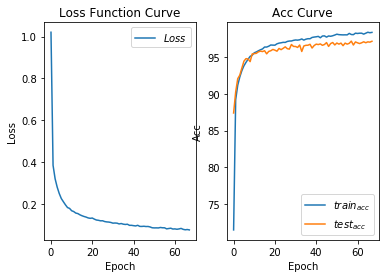

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

# 定义神经网络模型
class MultiLayerNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        super(MultiLayerNet, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# 读取数据
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

# 设置超参数
input_size = 784
hidden_sizes = [50, 45, 50]  # 用户可以指定每个隐藏层的神经元数
output_size = 10
activation = 'relu'  # 可选: 'relu', 'sigmoid', 'tanh'
optimizer_type = 'adam'  # 可选: 'sgd', 'adam', 'momentum', 'adagrad'
weight_decay = 0.001  # L2正则化的权重衰减参数

# 初始化神经网络模型
network = MultiLayerNet(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, activation=activation)

# 选择优化器
if optimizer_type == 'sgd':
    optimizer = optim.SGD(network.parameters(), lr=0.05, momentum=0.9, weight_decay=weight_decay)
elif optimizer_type == 'adam':
    optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=weight_decay)
elif optimizer_type == 'momentum':
    optimizer = optim.SGD(network.parameters(), lr=0.05, momentum=0.9, weight_decay=weight_decay)
elif optimizer_type == 'adagrad':
    optimizer = optim.Adagrad(network.parameters(), lr=0.01, weight_decay=weight_decay)
else:
    raise ValueError("Invalid optimizer type. Please choose from 'sgd', 'adam', 'momentum', or 'adagrad'.")

criterion = nn.CrossEntropyLoss()

train_loss_list = []
train_acc_list = []
test_acc_list = []

best_acc = 0.0
early_stop = False
patience = 10  # 控制早停的参数

# 训练
for epoch in range(100):
    if not early_stop:
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images = images.view(-1, 784)
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            # 添加 L2 正则化
            l2_reg = torch.tensor(0.)
            for param in network.parameters():
                l2_reg += torch.norm(param)
            loss += weight_decay * l2_reg
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(100 * correct_train / total_train)

        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 784)
                outputs = network(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
            test_acc = 100 * correct_test / total_test
            test_acc_list.append(test_acc)
            print(f'Epoch [{epoch + 1}/100], Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.2f}%, Test Acc: {test_acc:.2f}%')

            # 早停法：如果验证集性能不再提高，则停止训练
            if test_acc > best_acc:
                best_acc = test_acc
                patience = 10  # 重置耐心计数器
            else:
                patience -= 1
                if patience == 0:
                    print("Early stopping.")
                    early_stop = True
                    break

# 绘制 loss 曲线
plt.subplot(1, 2, 1)
plt.title('Loss Function Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_list, label="$Loss$")
plt.legend()

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.title('Acc Curve')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.plot(train_acc_list, label="$train_{acc}$")
plt.plot(test_acc_list, label="$test_{acc}$")
plt.legend()
plt.show()